In [30]:
import os
import glob
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = sns.color_palette()
plt.style.use("fivethirtyeight")

#!pip install xgboost
import xgboost as xb

from sklearn.metrics import mean_squared_error

#import kaggle
#!kaggle datasets download -d robikscube/hourly-energy-consumption

In [2]:
def get_csv(filename):
    with ZipFile(filename, "r") as zip:
        zip.extractall()

    cd, csv_files = os.getcwd(), []
    for file_name in glob.glob(cd+"\*.csv"): 
        csv_files.append(file_name.replace(cd+"\\", ""))

    return csv_files

filename = "hourly-energy-consumption.zip"
files = get_csv(filename)
files

['AEP_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'DEOK_hourly.csv',
 'DOM_hourly.csv',
 'DUQ_hourly.csv',
 'EKPC_hourly.csv',
 'FE_hourly.csv',
 'NI_hourly.csv',
 'PJME_hourly.csv',
 'PJMW_hourly.csv',
 'pjm_hourly_est.csv',
 'PJM_Load_hourly.csv']

In [5]:
def tsdf(filename):
    df = pd.read_csv(filename)
    df.set_index("Datetime", inplace=True)
    df.index = pd.to_datetime(df.index)
    
    return df

n=-4
file = files[n]
df = tsdf(file)
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


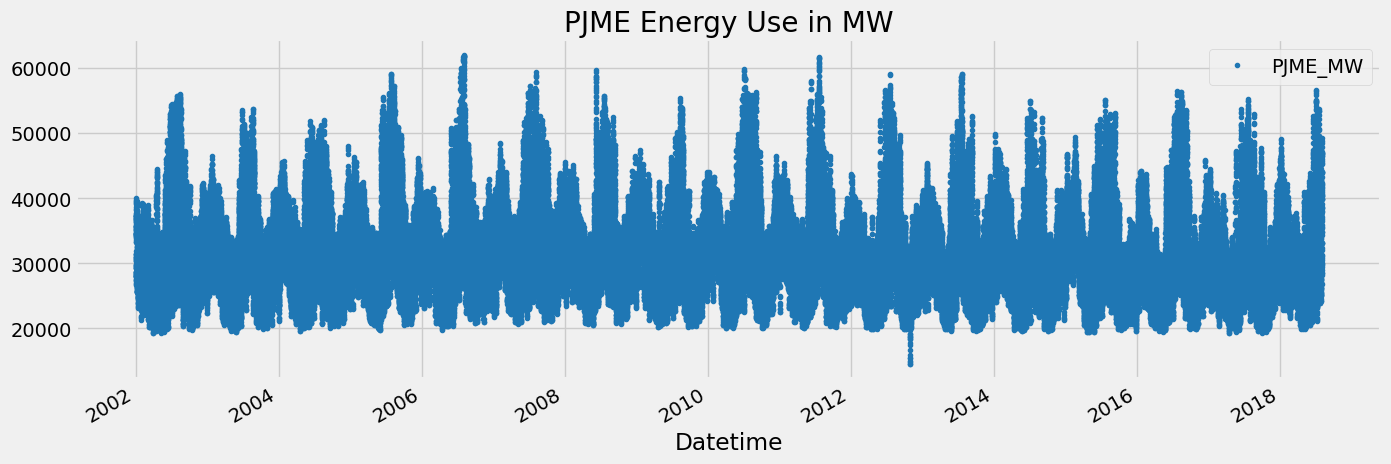

In [6]:
df.plot(style=".",
        figsize=(15,5),
        color = color_palette[0],
        title = "PJME Energy Use in MW"
       )
plt.show()

In [7]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

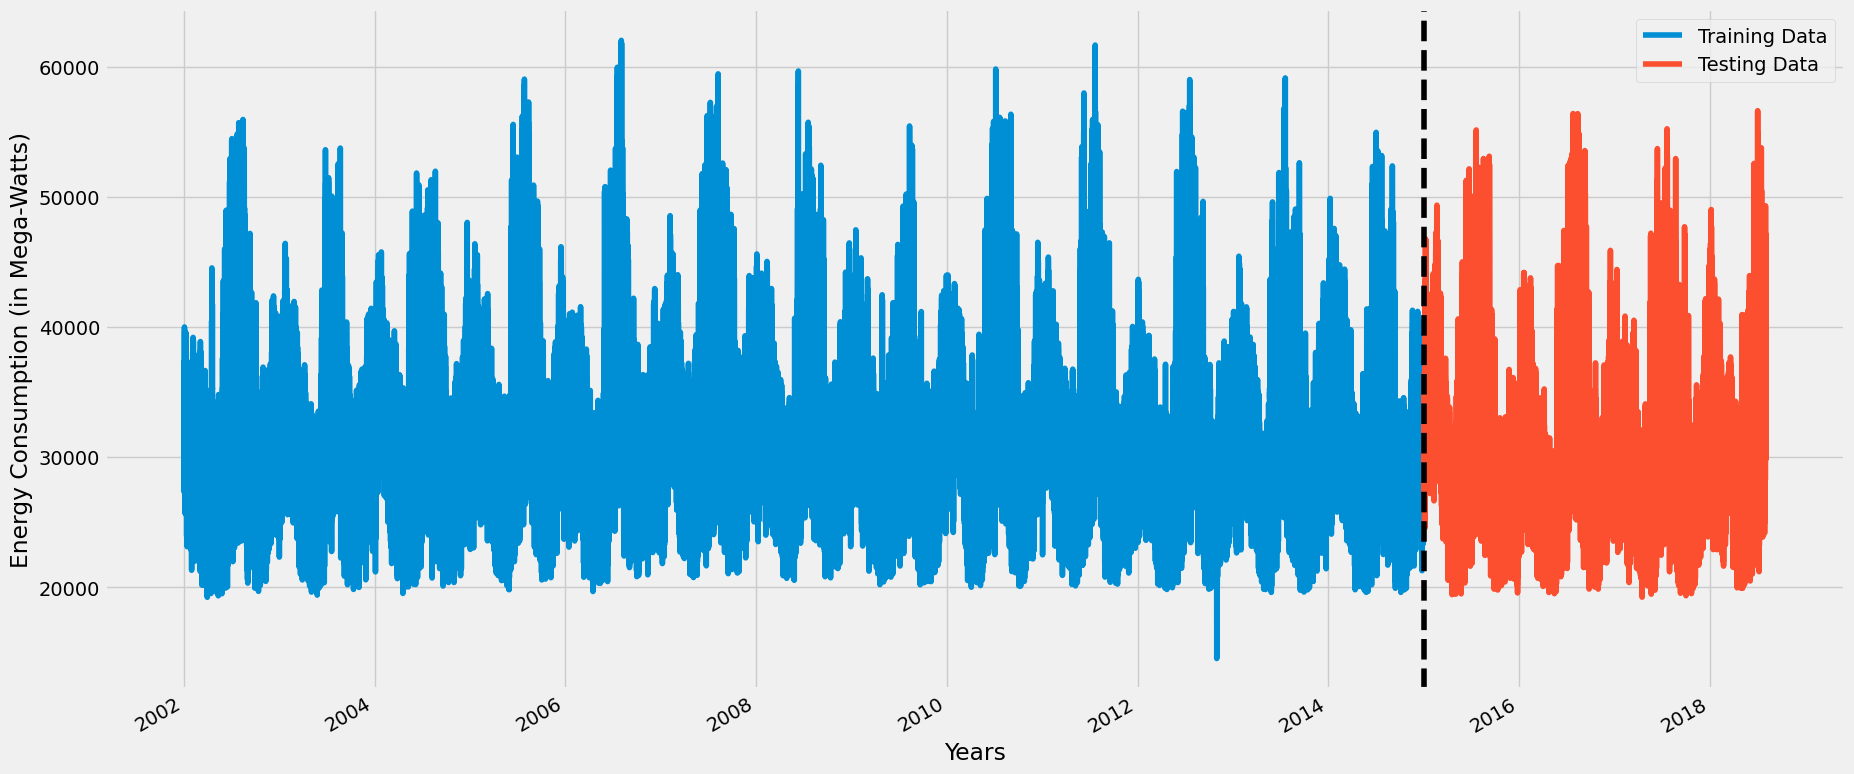

In [8]:
figure, axes = plt.subplots(figsize=(20,10))
train.plot(ax = axes)
test.plot(ax = axes)
axes.axvline('01-01-2015', color="black", ls="--")
axes.legend(["Training Data", "Testing Data"])
plt.ylabel("Energy Consumption (in Mega-Watts)")
plt.xlabel("Years")
plt.show()

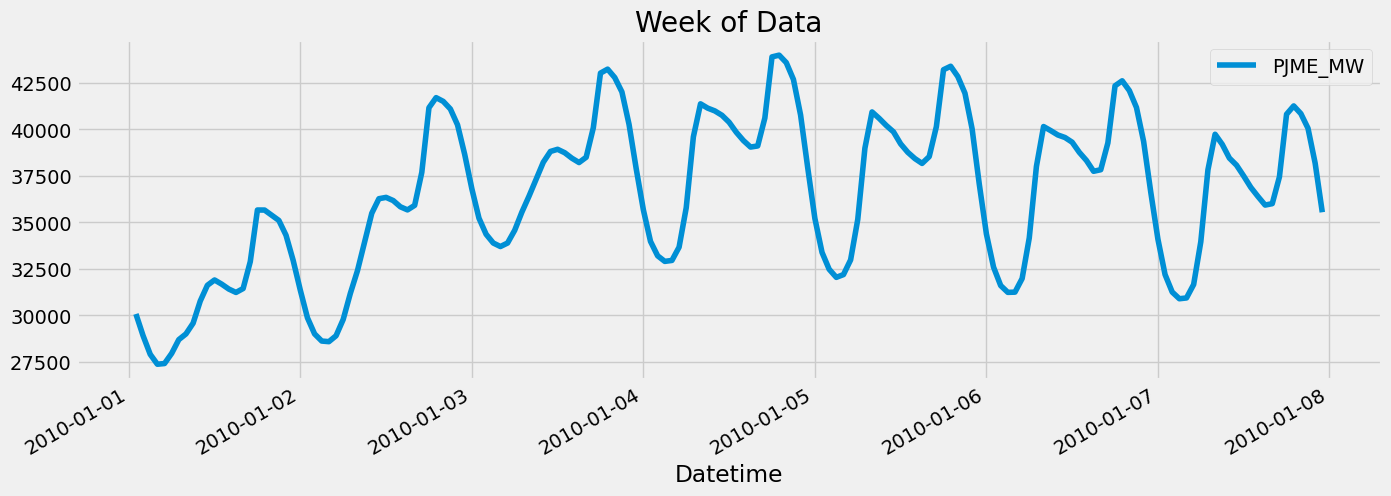

In [9]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(figsize=(15,5),
                                                               title = "Week of Data"
                                                              )
plt.show()

In [32]:
def add_features(df):
    if df.index.dtype == "<M8[ns]":
        df = df.copy()
        df["hour"] = df.index.hour
        df["dayofweek"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df["month"] = df.index.month
        df["year"] = df.index.year
        df["dayofyear"] = df.index.dayofyear
    
    return df

df = add_features(df)
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2


In [27]:
def viz_boxplots(data = None, x = None, y= None):
    figure, axes = plt.subplots(figsize=(10,8))
    sns.boxplot(data=data, x = x, y = y)
    axes.set_title("MW per "+x)
    plt.show()
    return

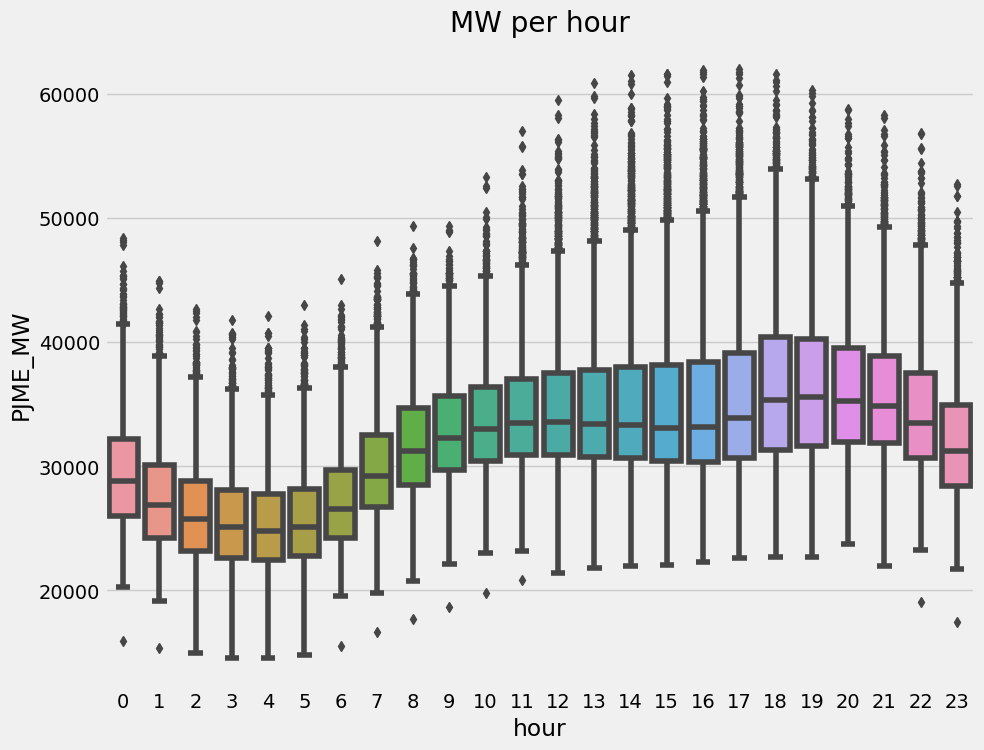

In [28]:
viz_boxplots(data = df, 
             x = "hour", 
             y = "PJME_MW")

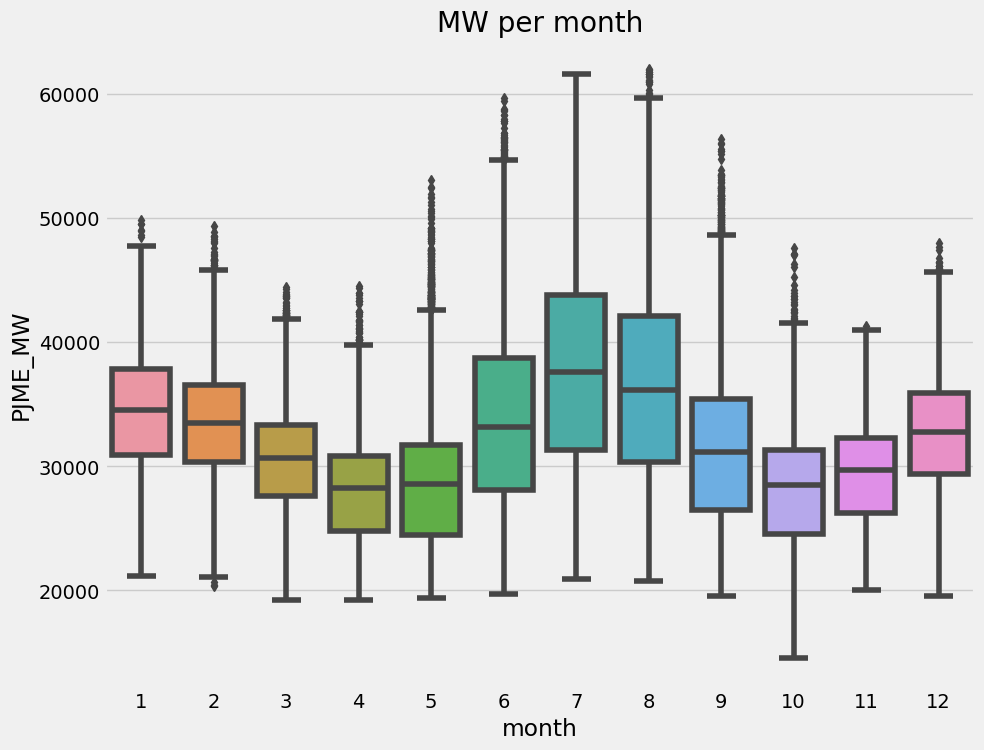

In [29]:
viz_boxplots(data = df, 
             x = "month", 
             y = "PJME_MW")

In [33]:
train = add_features(train)
test = add_features(test)

In [41]:
FEATURES = list(train.columns)
TARGET = FEATURES.pop(0)

print(FEATURES, "\n", TARGET)

['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'] 
 PJME_MW


In [42]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [45]:
regressor = xb.XGBRegressor(n_estimators = 1000,
                            early_stopping_rounds = 50,
                            learning_rate = 0.01
                           )
regressor.fit(x_train, 
              y_train,
              eval_set = [(x_train, y_train),
                          (x_test,y_test)],
              verbose=True
             )

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	validation_0-rmse:28660.79477	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63482	validation_1-rmse:27422.93837
[15]	validation_0-rmse:28099.33236	

[127]	validation_0-rmse:9639.34517	validation_1-rmse:8943.22685
[128]	validation_0-rmse:9553.83381	validation_1-rmse:8860.74829
[129]	validation_0-rmse:9468.90731	validation_1-rmse:8783.77605
[130]	validation_0-rmse:9385.18620	validation_1-rmse:8702.78904
[131]	validation_0-rmse:9302.13036	validation_1-rmse:8628.24670
[132]	validation_0-rmse:9219.96985	validation_1-rmse:8553.50065
[133]	validation_0-rmse:9139.05976	validation_1-rmse:8475.63618
[134]	validation_0-rmse:9058.77815	validation_1-rmse:8401.78999
[135]	validation_0-rmse:8979.33354	validation_1-rmse:8329.68884
[136]	validation_0-rmse:8900.82328	validation_1-rmse:8257.61035
[137]	validation_0-rmse:8823.16493	validation_1-rmse:8187.47943
[138]	validation_0-rmse:8746.40369	validation_1-rmse:8117.30033
[139]	validation_0-rmse:8670.69319	validation_1-rmse:8044.94586
[140]	validation_0-rmse:8595.30150	validation_1-rmse:7974.50892
[141]	validation_0-rmse:8521.03848	validation_1-rmse:7903.61734
[142]	validation_0-rmse:8447.53338	valid

[256]	validation_0-rmse:3927.56280	validation_1-rmse:4126.40487
[257]	validation_0-rmse:3909.69820	validation_1-rmse:4116.66382
[258]	validation_0-rmse:3893.02728	validation_1-rmse:4105.37452
[259]	validation_0-rmse:3877.19328	validation_1-rmse:4095.87654
[260]	validation_0-rmse:3860.91496	validation_1-rmse:4086.11364
[261]	validation_0-rmse:3844.68215	validation_1-rmse:4075.07671
[262]	validation_0-rmse:3829.43135	validation_1-rmse:4066.33859
[263]	validation_0-rmse:3813.64350	validation_1-rmse:4056.79027
[264]	validation_0-rmse:3798.97077	validation_1-rmse:4048.14058
[265]	validation_0-rmse:3782.79682	validation_1-rmse:4039.45958
[266]	validation_0-rmse:3767.96005	validation_1-rmse:4030.05158
[267]	validation_0-rmse:3753.73564	validation_1-rmse:4021.88378
[268]	validation_0-rmse:3739.05516	validation_1-rmse:4013.20004
[269]	validation_0-rmse:3724.68055	validation_1-rmse:4004.95299
[270]	validation_0-rmse:3710.68657	validation_1-rmse:3995.70681
[271]	validation_0-rmse:3696.70657	valid

[385]	validation_0-rmse:2930.45197	validation_1-rmse:3717.54549
[386]	validation_0-rmse:2928.40947	validation_1-rmse:3716.98411
[387]	validation_0-rmse:2924.75154	validation_1-rmse:3717.23919
[388]	validation_0-rmse:2922.74662	validation_1-rmse:3716.75390
[389]	validation_0-rmse:2918.65801	validation_1-rmse:3717.04523
[390]	validation_0-rmse:2914.96604	validation_1-rmse:3717.22400
[391]	validation_0-rmse:2913.07012	validation_1-rmse:3716.73675
[392]	validation_0-rmse:2909.27608	validation_1-rmse:3717.36197
[393]	validation_0-rmse:2906.62094	validation_1-rmse:3717.37200
[394]	validation_0-rmse:2903.57242	validation_1-rmse:3717.49762
[395]	validation_0-rmse:2900.99520	validation_1-rmse:3717.56557
[396]	validation_0-rmse:2896.24892	validation_1-rmse:3716.95968
[397]	validation_0-rmse:2894.50112	validation_1-rmse:3716.66088
[398]	validation_0-rmse:2889.88620	validation_1-rmse:3716.12758
[399]	validation_0-rmse:2887.30360	validation_1-rmse:3716.23487
[400]	validation_0-rmse:2884.85132	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
feature_importance_df = pd.DataFrame(data = regressor.feature_importances_,
                                     index = regressor.feature_names_in_,
                                     columns = ["importance"]
                                    )
feature_importance_df

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


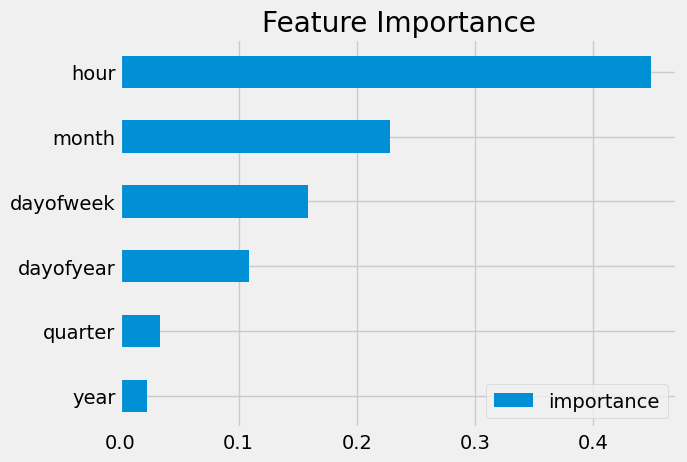

In [47]:
feature_importance_df.sort_values("importance").plot(kind="barh",
                                                     title="Feature Importance"
                                                    )
plt.show()

In [48]:
test["prediction"] = regressor.predict(x_test) 

In [49]:
df = df.merge(test["prediction"],
              how = "left",
              left_index = True,
              right_index = True
             )
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40829.566406
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40358.277344
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39135.480469
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,35866.378906
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,31363.611328


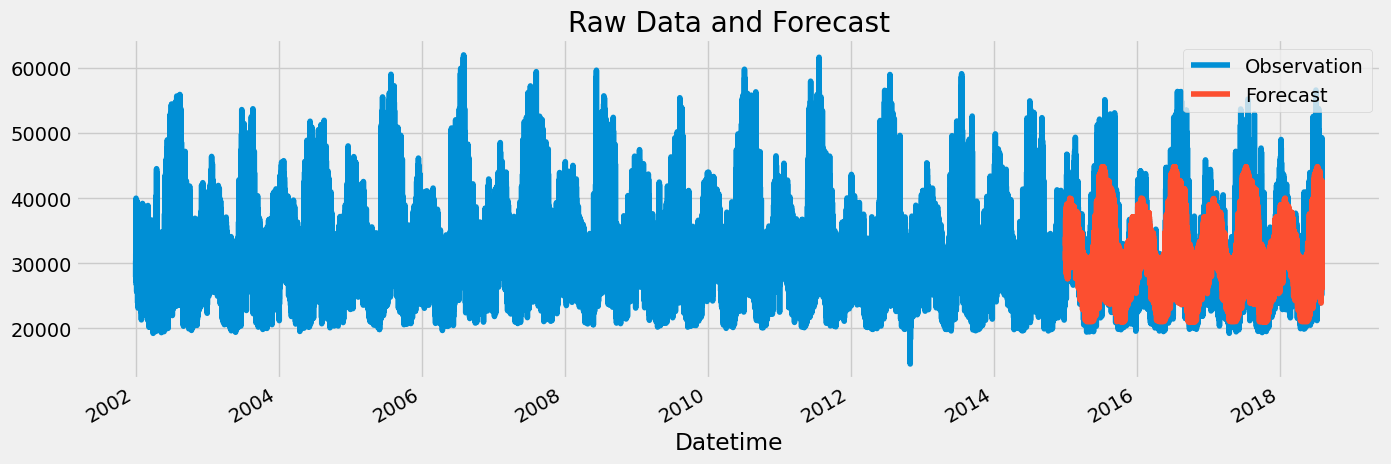

In [52]:
axes = df["PJME_MW"].plot(figsize=(15,5))
df["prediction"].plot(ax = axes)
plt.legend(["Observation","Forecast"])
axes.set_title("Raw Data and Forecast")
plt.show()

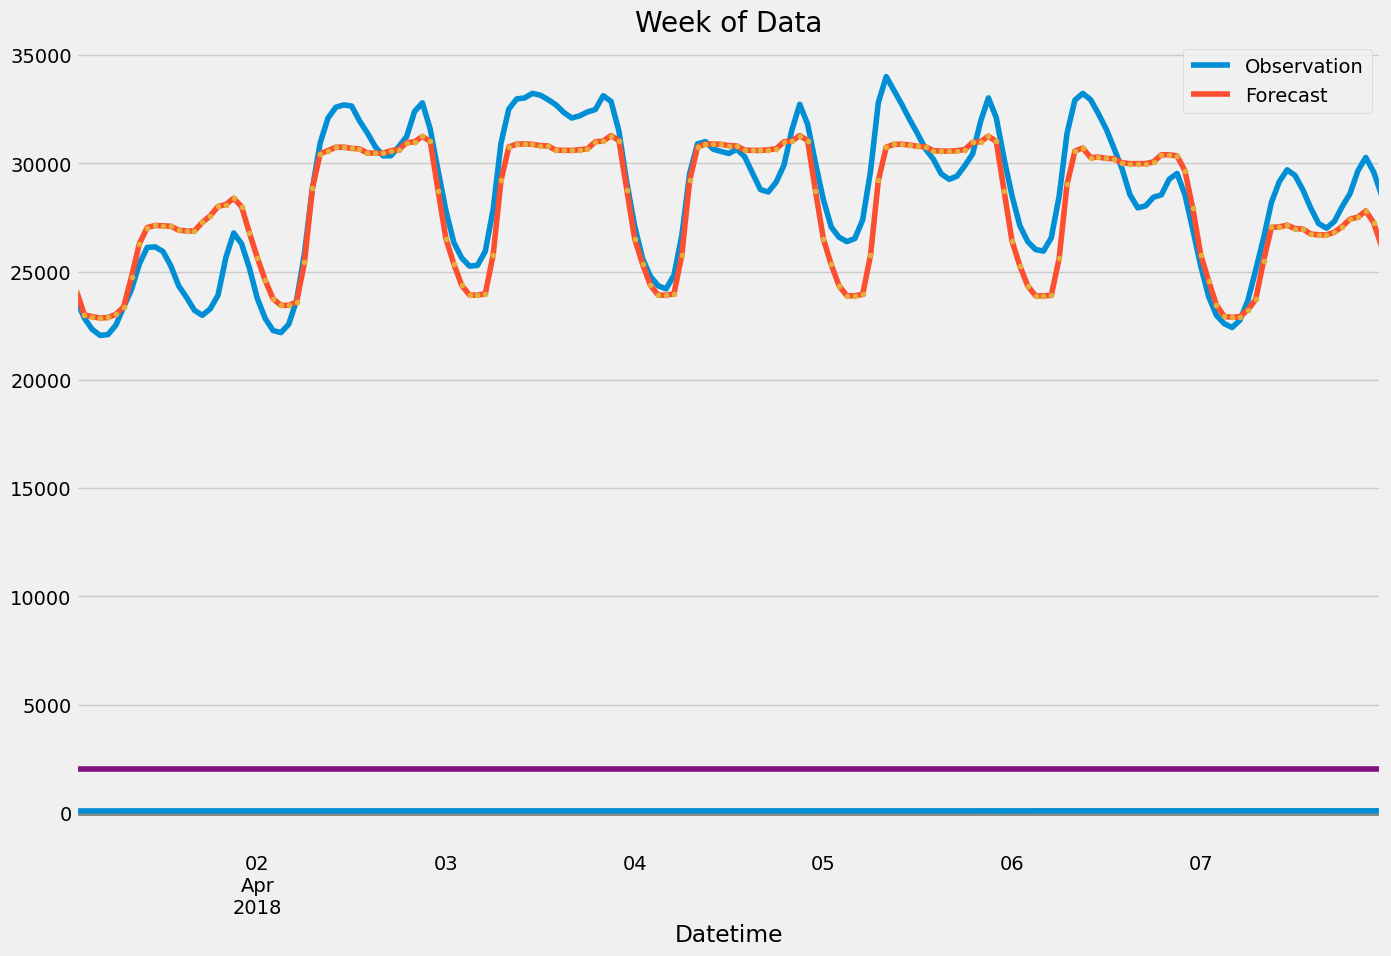

In [58]:
axes = df.loc[(df.index > "04-01-2018") & 
              (df.index < "04-08-2018")].plot(figsize=(15,10),
                                              title = "Week of Data"
                                             )
df.loc[(df.index > "04-01-2018") & 
       (df.index < "04-08-2018")]["prediction"].plot(style=".")
plt.legend(["Observation","Forecast"])
plt.show()

In [59]:
score = np.sqrt(mean_squared_error(test["PJME_MW"],
                                   test["prediction"]
                                  ))
print(f"RMSE = {score}")

RMSE = 3715.9314164142415


In [60]:
test["error"] = np.abs(test[TARGET] - test["prediction"])
test["date"] = test.index.date

In [61]:
# worst predicted days
test.groupby(['date'])["error"].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
2018-01-06    10903.514486
2015-02-20    10818.344727
2016-08-11    10390.962891
2018-01-07    10189.657715
2017-05-19    10180.837646
Name: error, dtype: float64

In [62]:
# best predicted days
test.groupby(['date'])["error"].mean().sort_values(ascending=True).head(10)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
2015-09-25    502.371094
2015-10-28    507.922445
2017-05-02    514.495768
2017-06-16    524.565267
2017-12-08    527.530436
Name: error, dtype: float64